In [1]:
%load_ext autoreload
%autoreload 2

#### 1. Set up the reaction graph from DFT data 

In [2]:
from arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=5
)

/Users/badw/github-projects/arcs/src/arcs/generate.py:255: RuntimeWarning: overflow encountered in exp
  K = np.exp(


#### 2. Sample the `graph`

In [7]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    )

t = Traversal(graph=graph)

data = t.sample(initial_concentrations=gic,ncpus=4,nsamples=1000)

1008it [00:52, 19.35it/s]                         


#### 3. generate reaction statistics

In [27]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling()
stats = pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)
stats.head(10)

1 H2 + 1 SO2 = 1 O2 + 1 H2S              369
1 H2O + 1 SO2 = 1 H2SO3                  270
2 H2 + 1 O2 = 2 H2O                      227
3 O2 + 2 H2S = 2 H2O + 2 SO2             163
3 H2 + 1 SO2 = 2 H2O + 1 H2S             136
1 H2O + 1 NO2 + 1 NO = 2 HNO2            115
1 H2 + 1 SO2 + 1 NO2 = 1 H2SO3 + 1 NO    114
1 H2O + 2 NO2 = 1 HNO3 + 1 HNO2           78
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2            72
1 H2 + 1 NO2 = 1 H2O + 1 NO               68
dtype: int64

#### 4. generate mean concentrations and differences

In [20]:
average_data = pd.DataFrame(analysis.average_sampling(data))
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.sort_values(by='diff',inplace=True)
average_data.round(2)

,initial,mean,diff,sem,std,var
H2S,10.0,4.58,-5.42,0.10,4.78,22.87
O2,10.0,5.39,-4.61,0.12,5.59,31.19
NO2,10.0,6.42,-3.58,0.10,4.78,22.89
H2O,30.0,30.00,-0.00,0.13,6.06,36.77
NH3,0.0,0.02,0.02,0.01,0.39,0.15
S8,0.0,0.09,0.09,0.01,0.30,0.09
NOHSO4,0.0,0.25,0.25,0.02,1.15,1.32
N2,0.0,0.44,0.44,0.03,1.34,1.79
H2SO3,0.0,0.44,0.44,0.04,2.00,4.00
HNO2,0.0,0.52,0.52,0.04,1.76,3.09


#### 5. Plot 

In [21]:
average_data.reset_index()

,index,initial,mean,diff,sem,std,var
0,H2S,10.0,4.579627,-5.420373,0.098772,4.782057,22.868067
1,O2,10.0,5.393969,-4.606031,0.115360,5.585148,31.193880
2,NO2,10.0,6.418176,-3.581824,0.098818,4.784241,22.888961
3,H2O,30.0,29.995735,-0.004265,0.125255,6.064190,36.774401
4,NH3,0.0,0.022681,0.022681,0.008007,0.387658,0.150279
5,S8,0.0,0.087508,0.087508,0.006125,0.296519,0.087924
6,NOHSO4,0.0,0.249881,0.249881,0.023722,1.148487,1.319022
7,N2,0.0,0.439030,0.439030,0.027600,1.336247,1.785556
8,H2SO3,0.0,0.443085,0.443085,0.041321,2.000540,4.002159
9,HNO2,0.0,0.519826,0.519826,0.036285,1.756727,3.086089


/var/folders/40/xmstzxyn7377k__pn0yxn6w80000gn/T/ipykernel_68929/949321809.py:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



<Axes: >

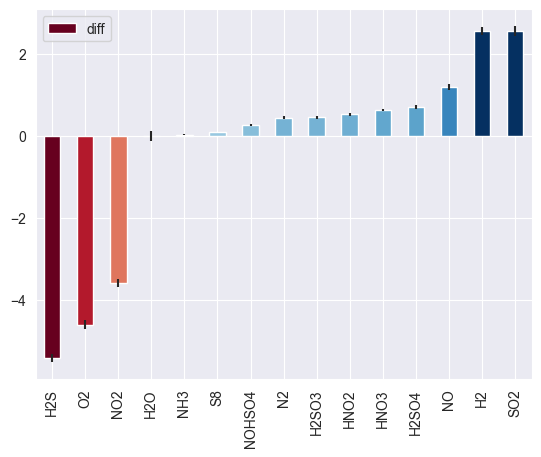

In [22]:
import seaborn as sns 
from matplotlib.cm import get_cmap
import matplotlib.colors as colors
sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(
    vmin=average_data['diff'].min(), vmax=average_data['diff'].max()
    )
cmap = get_cmap(name='RdBu')  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='sem',color=bar_colors)

#### 5. generate a `pyvis` graph 

In [ ]:
pyvis_kwargs = {'width':'50%','notebook':False,"font_color":'white'}
g = analysis.result_to_pyvis(data,head=10)
g.save_graph(name="example_pyvis_graph.html")